# Import package


In [30]:
import requests
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import autograd.numpy as anp
from autograd import grad, jacobian
from scipy.optimize import line_search, minimize
import datetime
from typing import List

# import algorithm 
%run ./Note.ipynb

# Data import and processing


In [2]:
settledate = pd.to_datetime(datetime.date.today())
bonds = pd.DataFrame(
    json.loads(
        requests.get(
            "https://asx.api.markitdigital.com/asx-research/1.0/bonds/government/exchange-traded?height=179&width=690"
        ).content
    )["data"]["items"]
)
bonds["maturity"] = bonds["securityDescription"].str.extract(r"(\d{2}-\d{2}-\d{2})")[0]
bonds["maturity"] = pd.to_datetime(bonds["maturity"], format="%d-%m-%y")
bonds = bonds[["maturity", "couponPercent", "priceBid", "priceAsk"]]
bonds["couponPercent"] = bonds["couponPercent"].astype(float) / 100
bonds.dropna(inplace=True)
bonds.reset_index(drop=True, inplace=True)
bonds.sort_values("maturity", inplace=True)
bonds

,maturity,couponPercent,priceBid,priceAsk
10,2025-11-21,0.0025,98.21,99.90
1,2026-04-21,0.0425,100.80,103.00
2,2027-04-21,0.0475,103.00,104.90
11,2027-11-21,0.0275,97.00,100.07
6,2028-05-21,0.0225,97.84,98.10
3,2029-04-21,0.0325,99.40,99.82
4,2033-04-21,0.0450,103.50,104.48
5,2037-04-21,0.0375,94.10,97.00
8,2039-06-21,0.0325,86.50,92.40
7,2041-05-21,0.0275,79.11,84.19


# Support function


In [3]:
def year_transform(date: pd.Timestamp) -> float:
    """Transform date to actual year"""
    if date == settledate:
        return 0
    years = date.year - settledate.year
    check_date = pd.Timestamp(
        year=date.year,
        month=settledate.month,
        day=settledate.day,
    )
    years += (date - check_date).days / abs(
        (
            check_date
            + pd.DateOffset(years=np.sign((date - check_date).days))
            - check_date
        ).days
    )
    return years


def coupon_date_generate(maturity: pd.Timestamp) -> np.ndarray:
    """Generate coupon dates"""
    coupon_dates = [maturity]
    while maturity - pd.DateOffset(months=6) > settledate:
        maturity -= pd.DateOffset(months=6)
        coupon_dates.append(maturity)
    return np.array(list(map(year_transform, coupon_dates[::-1])))

# Discount factor formula


In [4]:
def discount_factor(params: np.ndarray, t: np.ndarray) -> np.ndarray:
    """Calculate discount factor"""
    f0, f1, f2, gamma = params
    return np.exp(
        -(
            f0 * t
            + f1 * (gamma - np.exp(-t / gamma) * gamma)
            + f2 * (gamma - np.exp(-t / gamma) * (t + gamma))
        )
    )

# Bond pricing formula

In [5]:
def bond_valuation(params: np.ndarray, maturity: pd.Timestamp, coupon: float) -> float:
    """Calculate bond valuation"""
    t = coupon_date_generate(maturity)
    cf = np.ones_like(t) * coupon / 2
    cf[-1] += 1
    return 100 * np.sum(cf * discount_factor(params, t))

# Loss function

In [6]:
def loss_function(
    params: np.ndarray, maturity: pd.Timestamp, coupon: float, bid: float, ask: float
) -> float:

    """Objective function for optimization"""

    bond_price = bond_valuation(params, maturity, coupon)

    return (max(0, bond_price - ask) / ask) ** 2 + (max(0, bid - bond_price) / bid) ** 2

# Discount factor curve

In [7]:
def plot(params: List[float]):
    t = np.linspace(0, 30, 100000)
    dfs = discount_factor(params, t)
    plt.figure(figsize=(15, 6))
    plt.plot(t, dfs)
    plt.title("Discount Factor Curve")
    plt.xlabel("Years")
    plt.ylabel("Discount Factor")
    plt.grid()
    plt.show()

# Testing with package optimizer

In [8]:
def target(params: np.ndarray) -> float:
    """Target function to be minimized"""
    return np.sum(
        [
            loss_function(
                params,
                row["maturity"],
                row["couponPercent"],
                row["priceBid"],
                row["priceAsk"],
            )
            for _, row in bonds.iterrows()
        ]
    )


params = minimize(
    target,
    np.array([0.03, 0.03, 0.03, 1]),
    method="L-BFGS-B",
)

In [9]:
params

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 0.0
        x: [ 5.272e-02 -1.175e-02 -5.018e-02  1.685e+00]
      nit: 43
      jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
     nfev: 240
     njev: 48
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

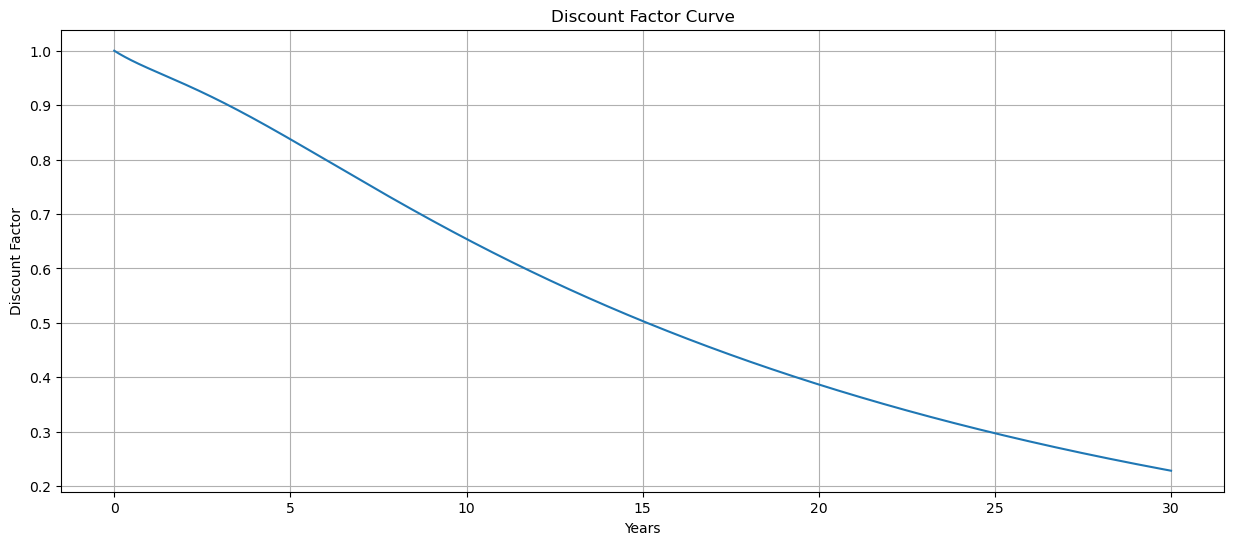

In [10]:
plot(params.x)

In [11]:
# 2) rebuild a tiny wrapper of your target that uses anp instead of np
def target_ag(params):
    # `bonds` is still a pandas DataFrame of market data,
    # but inside here we only call anp routines.
    return np.sum(
        [
            loss_function(
                params,
                row["maturity"],
                row["couponPercent"],
                row["priceBid"],
                row["priceAsk"],
            )
            for _, row in bonds.iterrows()
        ]
    )
# 3) take the gradient
jac_ag = grad(target_ag)

# 4) pick your starting guess x0 and initial H matrix
x0 = anp.array([0.03, 0.03, 0.03, 1.0])      # β₀, β₁, β₂, τ
H0 = anp.eye(len(x0))                        # identity inverse‐Hessian

# Fletcher-Reeves Optimization method

In [25]:
res = fletcher_reeves(
    fun=target_ag,
    x0=x0,
    jac=jac_ag)
print("Fletcher-Reeves finished at", res)

Fletcher-Reeves finished at  message: Function change below tolerance
 success: True
  status: 0
     fun: 0.00012423718599201232
       x: [ 5.159e-02  2.025e-02 -1.033e-01  1.012e+00]
     nit: 32
    nfev: 327
    njev: 65


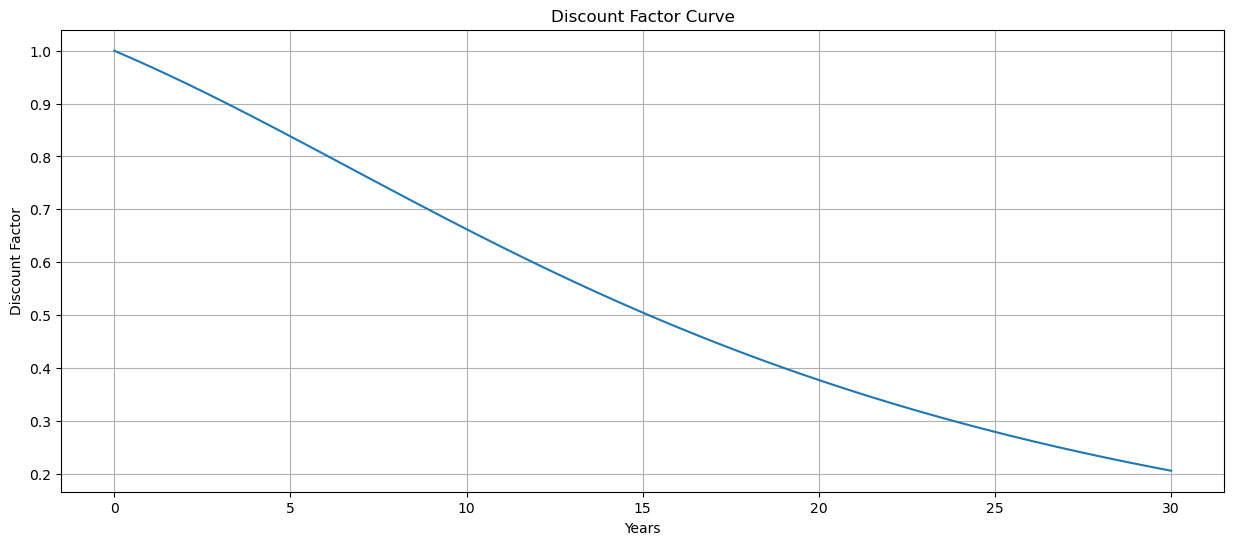

In [32]:
plot(res.x)

# DFP Optimization method

In [33]:
res = dfp(
    fun=target_ag,
    x0=x0,
    jac=jac_ag,
    H_k=H0,
    maxiter=200,
    logs=False
)
print("DFP finished at", res)

DFP finished at  message: Gradient norm below tolerance
 success: True
  status: 0
     fun: 0.0
       x: [ 6.196e-02 -3.351e-02 -1.917e-02  5.286e+00]
     nit: 74
    nfev: 178
    njev: 161


/opt/conda/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")
/opt/conda/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


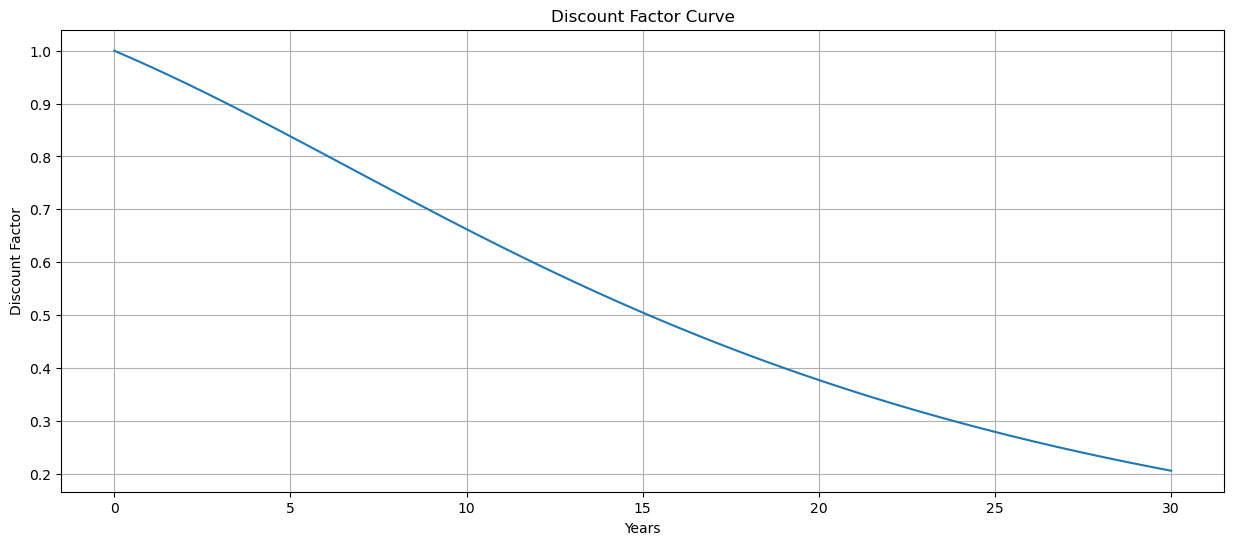

In [34]:
plot(res.x)